In [15]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(16,8))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p
import lin_lib as ll
import demodulation_lib as dl
from qubic.utils import progress_bar

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import scipy.signal as scsig
from scipy import interpolate

In [32]:
day = '2019-03-19'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.sort(glob.glob(data_dir+'*swich*'))
print (dirs)
print (len(dirs))

labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
print labels

thedir = dirs[9]
print(thedir)

['/qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42'
 '/qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_cl

## Reading Data for a given asic

In [33]:
AsicNum = 2
a = qp()
a.read_qubicstudio_dataset(thedir, asic=AsicNum)

Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Sums/science-asic2-2019.03.19.134429.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Sums/science-asic2-2019.03.19.134429.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-MMR-2019.03.19.134430.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-MMR-2019.03.19.134430.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-intern-2019.03.19.134533.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-intern-2019.03.19.134533.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/conf-asics-2019.03.19.134431.fits
Reading QubicStudio FITS file: 

## Reading TES Data

76294


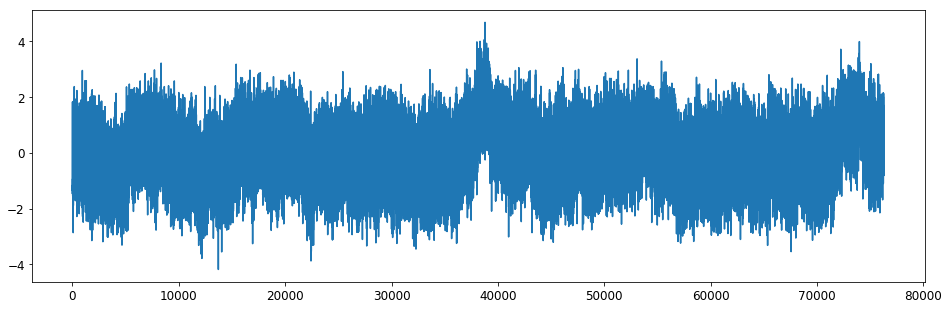

In [54]:
TESNum = 44
data = a.timeline(TES=TESNum)
#data = data[:18000]
t_data = a.timeline_timeaxis(axistype='index')
#t_data = t_data[:18000]
print(len(t_data))
#plot(t_data)
#a.plot_timestamp_diagnostic()
#plot(t_data, (data-np.mean(data))/np.std(data), label='Data')
plot((data-np.mean(data))/np.std(data), label='Data')
#xlim((400+1.553001e9,520+1.553001e9))


## Let's use the amplitude of the first harmonic in the data as a measure of the signal

FREQ_SAMPLING = 156.25
Period_SAMPLING = 0.0064
Fitting with Minuit
correcting errorbars to have chi2/ndf=1 - correction = 2.68151558364e+15
[3.33000000e-01 2.99192862e-03 4.36957080e+08 3.80859300e+06]
[0.00000000e+00 6.69973519e-05 8.12074369e+06 5.49052128e+05]
('Chi2=', 2681515583644789.0)
('ndf=', 94)
Amplitude = 436957079.811


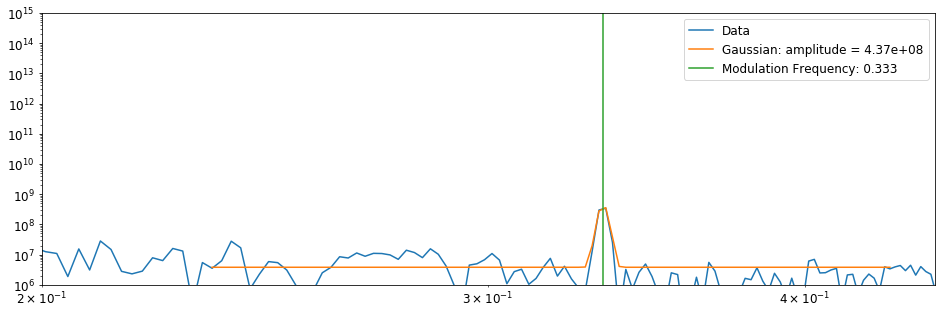

In [55]:
reload(dl)
period_sampling = t_data[1] - t_data[0]
FREQ_SAMPLING = 1. / (t_data[1] - t_data[0])
print('FREQ_SAMPLING = {}'.format(FREQ_SAMPLING))
print('Period_SAMPLING = {}'.format(period_sampling))

spectrum_f, freq_f = mlab.psd(data, Fs=FREQ_SAMPLING, NFFT=len(data), 
                              window=mlab.window_hanning)

freq_mod = 0.333
okfit = np.abs(freq_f-freq_mod) < 0.1

guess = np.array([freq_mod, 0.01, np.max(spectrum_f[okfit]), np.median(spectrum_f[okfit])])
res = ft.do_minuit(freq_f[okfit], spectrum_f[okfit], np.ones(okfit.sum()), guess, 
                   functname=dl.gauss, fixpars=[1,0,0,0,0], 
                   nohesse=True,
                   force_chi2_ndf=True)

# Look at the amplitude of the peak
print('Amplitude = {}'.format(res[1][2]))

plot(freq_f, spectrum_f,label='Data')
plot(freq_f[okfit], dl.gauss(freq_f[okfit], res[1]), 
     label='Gaussian: amplitude = {0:5.3g}'.format(res[1][2]))
plot([freq_mod, freq_mod], [1e6, 1e15], label='Modulation Frequency: {}'.format(freq_mod))
yscale('log')
xscale('log')
xlim(0.2,0.45)
ylim(1e6, 1e15)
legend()

### Now do the same on both asics and all TES

In [50]:
allres = np.zeros((256,4))
allerr = np.zeros((256,4))

for AsicNum in [1,2]:
    a = qp()
    a.read_qubicstudio_dataset(thedir, asic=AsicNum)
    t_data = a.timeline_timeaxis(axistype='index')
    FREQ_SAMPLING = 1. / (t_data[1] - t_data[0])
    bar = progress_bar(128, 'ASIC #{}'.format(AsicNum))
    for TESNum in np.arange(128)+1:
        bar.update()
        TESindex = (TESNum-1) + 128 * (AsicNum-1)
        thedata = a.timeline(TES=TESNum)
        spectrum_f, freq_f = mlab.psd(thedata, Fs=FREQ_SAMPLING, NFFT=len(thedata), 
                              window=mlab.window_hanning)
        freq_mod = 0.333
        okfit = np.abs(freq_f-freq_mod) < 0.1
        guess = np.array([freq_mod, 0.01, np.max(spectrum_f[okfit]), np.median(spectrum_f[okfit])])
        res = ft.do_minuit(freq_f[okfit], spectrum_f[okfit], np.ones(okfit.sum()), guess, 
                   functname=dl.gauss, fixpars=[1,0,0,0,0], 
                   nohesse=True, verbose=False,
                   force_chi2_ndf=True)
        allres[TESindex,:] = res[1]
        allerr[TESindex,:] = res[2]
        

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Sums/science-asic1-2019.03.19.142321.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Sums/science-asic1-2019.03.19.142321.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-MMR-2019.03.19.142322.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-MMR-2019.03.19.142322.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-intern-2019.03.19.142321.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-intern-2019.03.19.142321.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/conf-asics-2019.03.19.142325.fits
Reading QubicStudio FITS file: 


Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Sums/science-asic2-2019.03.19.142321.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Sums/science-asic2-2019.03.19.142321.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-MMR-2019.03.19.142322.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-MMR-2019.03.19.142322.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-intern-2019.03.19.142321.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-intern-2019.03.19.142321.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/conf-asics-2019.03.19.142325.f

ASIC #1100%[=====================================================]Time: 0:00:58



Using TES temperature -1000.0mK




ASIC #2100%[=====================================================]Time: 0:00:48


1301959063.3080254
5006233866288.963


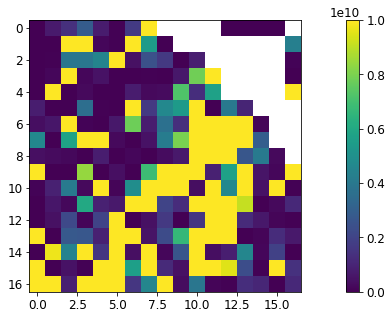

In [53]:
amps = allres[:,2]
img = ft.image_asics(all1=amps)
mm = np.median(amps)
print(mm)
ss = np.std(amps)
print(ss)
imshow(img, vmin=0, vmax=1e10)
colorbar()

# Now loop on all files

In [61]:
allres_tot = np.zeros((len(dirs),256,4))
allerr_tot = np.zeros((len(dirs),256,4))

from qubic.utils import progress_bar

for idir in xrange(len(dirs)):
    thedir = dirs[idir]
    for AsicNum in [1,2]:
        a = qp()
        a.read_qubicstudio_dataset(thedir, asic=AsicNum)
        t_data = a.timeline_timeaxis(axistype='index')
        FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
        bar = progress_bar(128, 'ASIC #{}'.format(AsicNum))
        for TESNum in np.arange(128)+1:
            bar.update()
            TESindex = (TESNum-1)+128*(AsicNum-1)
            thedata = a.timeline(TES=TESNum)
            spectrum_f, freq_f = mlab.psd(thedata, Fs=FREQ_SAMPLING, NFFT=len(thedata), 
                                  window=mlab.window_hanning)
            freq_mod = 0.333
            okfit = np.abs(freq_f-freq_mod) < 0.1
            guess = np.array([freq_mod, 0.01, np.max(spectrum_f[okfit]), np.median(spectrum_f[okfit])])
            res = ft.do_minuit(freq_f[okfit], spectrum_f[okfit], np.ones(okfit.sum()), guess, 
                       functname=dl.gauss, fixpars=[1,0,0,0,0], 
                       nohesse=True, verbose=False,
                       force_chi2_ndf=True)
            allres_tot[idir, TESindex,:] = res[1]
            allerr_tot[idir, TESindex,:] = res[2]

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Sums/science-asic1-2019.03.19.121230.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Sums/science-asic1-2019.03.19.121230.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/hk-MMR-2019.03.19.121230.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/hk-MMR-2019.03.19.121230.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/hk-intern-2019.03.19.121230.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/hk-intern-2019.03.19.121230.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/conf-asics-2019.03.19.121233.fits
Reading QubicStud


Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Sums/science-asic2-2019.03.19.121230.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Sums/science-asic2-2019.03.19.121230.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/hk-MMR-2019.03.19.121230.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/hk-MMR-2019.03.19.121230.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/hk-intern-2019.03.19.121230.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/hk-intern-2019.03.19.121230.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.12.30__swich_close_6_32/Hks/conf-asics-2019.

ASIC #1100%[=====================================================]Time: 0:00:52



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Sums/science-asic1-2019.03.19.122317.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Sums/science-asic1-2019.03.19.122317.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/hk-MMR-2019.03.19.122318.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/hk-MMR-2019.03.19.122318.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/hk-intern-2019.03.19.122317.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/hk-intern-2019.03.19.122317.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/conf-asics-2019.03.19.122318.f

ASIC #2100%[=====================================================]Time: 0:00:47



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Sums/science-asic2-2019.03.19.122317.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Sums/science-asic2-2019.03.19.122317.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/hk-MMR-2019.03.19.122318.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/hk-MMR-2019.03.19.122318.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/hk-intern-2019.03.19.122317.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/hk-intern-2019.03.19.122317.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.23.17__swich_all_open/Hks/conf-asics-2019.03.19.122318.f

ASIC #1100%[=====================================================]Time: 0:00:55



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Sums/science-asic1-2019.03.19.123421.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Sums/science-asic1-2019.03.19.123421.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/hk-MMR-2019.03.19.123421.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/hk-MMR-2019.03.19.123421.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/hk-intern-2019.03.19.123421.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/hk-intern-2019.03.19.123421.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/conf-asic

ASIC #2100%[=====================================================]Time: 0:00:46



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Sums/science-asic2-2019.03.19.123421.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Sums/science-asic2-2019.03.19.123421.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/hk-MMR-2019.03.19.123421.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/hk-MMR-2019.03.19.123421.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/hk-intern-2019.03.19.123421.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/hk-intern-2019.03.19.123421.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.34.21__swich_close_24_37/Hks/conf-asic

ASIC #1100%[=====================================================]Time: 0:01:00



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Sums/science-asic1-2019.03.19.124515.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Sums/science-asic1-2019.03.19.124515.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/hk-MMR-2019.03.19.124515.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/hk-MMR-2019.03.19.124515.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/hk-intern-2019.03.19.124515.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/hk-intern-2019.03.19.124515.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/conf-asic

ASIC #2100%[=====================================================]Time: 0:00:51



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Sums/science-asic2-2019.03.19.124515.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Sums/science-asic2-2019.03.19.124515.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/hk-MMR-2019.03.19.124515.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/hk-MMR-2019.03.19.124515.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/hk-intern-2019.03.19.124515.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/hk-intern-2019.03.19.124515.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.45.15__swich_close_45_56/Hks/conf-asic

ASIC #1100%[=====================================================]Time: 0:00:55



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Sums/science-asic1-2019.03.19.125434.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Sums/science-asic1-2019.03.19.125434.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/hk-MMR-2019.03.19.125434.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/hk-MMR-2019.03.19.125434.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/hk-intern-2019.03.19.125434.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/hk-intern-2019.03.19.125434.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/conf-asics-2019.03.19.125434.f

ASIC #2100%[=====================================================]Time: 0:00:44



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Sums/science-asic2-2019.03.19.125434.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Sums/science-asic2-2019.03.19.125434.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/hk-MMR-2019.03.19.125434.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/hk-MMR-2019.03.19.125434.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/hk-intern-2019.03.19.125434.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/hk-intern-2019.03.19.125434.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_12.54.34__swich_close_45/Hks/conf-asics-2019.03.19.125434.f

ASIC #1100%[=====================================================]Time: 0:01:02



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Sums/science-asic1-2019.03.19.130702.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Sums/science-asic1-2019.03.19.130702.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/hk-MMR-2019.03.19.130703.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/hk-MMR-2019.03.19.130703.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/hk-intern-2019.03.19.130752.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/hk-intern-2019.03.19.130752.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/conf-asics-2019.03.19.130704.f

ASIC #2100%[=====================================================]Time: 0:00:50



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Sums/science-asic2-2019.03.19.130702.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Sums/science-asic2-2019.03.19.130702.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/hk-MMR-2019.03.19.130703.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/hk-MMR-2019.03.19.130703.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/hk-intern-2019.03.19.130752.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/hk-intern-2019.03.19.130752.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.07.02__swich_close_56/Hks/conf-asics-2019.03.19.130704.f

ASIC #1100%[=====================================================]Time: 0:00:57



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Sums/science-asic1-2019.03.19.131606.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Sums/science-asic1-2019.03.19.131606.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/hk-MMR-2019.03.19.131606.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/hk-MMR-2019.03.19.131606.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/hk-intern-2019.03.19.131606.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/hk-intern-2019.03.19.131606.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/conf-asics-2019.03.19.131608.f

ASIC #2100%[=====================================================]Time: 0:00:50



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Sums/science-asic2-2019.03.19.131606.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Sums/science-asic2-2019.03.19.131606.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/hk-MMR-2019.03.19.131606.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/hk-MMR-2019.03.19.131606.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/hk-intern-2019.03.19.131606.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/hk-intern-2019.03.19.131606.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.16.06__swich_close_24/Hks/conf-asics-2019.03.19.131608.f

ASIC #1100%[=====================================================]Time: 0:00:57



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Sums/science-asic1-2019.03.19.132531.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Sums/science-asic1-2019.03.19.132531.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/hk-MMR-2019.03.19.132531.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/hk-MMR-2019.03.19.132531.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/hk-intern-2019.03.19.132531.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/hk-intern-2019.03.19.132531.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/conf-asics-2019.03.19.132532.f

ASIC #2100%[=====================================================]Time: 0:00:52



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Sums/science-asic2-2019.03.19.132531.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Sums/science-asic2-2019.03.19.132531.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/hk-MMR-2019.03.19.132531.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/hk-MMR-2019.03.19.132531.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/hk-intern-2019.03.19.132531.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/hk-intern-2019.03.19.132531.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.25.31__swich_close_37/Hks/conf-asics-2019.03.19.132532.f

ASIC #1100%[=====================================================]Time: 0:00:58



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Sums/science-asic1-2019.03.19.133519.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Sums/science-asic1-2019.03.19.133519.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/hk-MMR-2019.03.19.133519.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/hk-MMR-2019.03.19.133519.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/hk-intern-2019.03.19.133519.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/hk-intern-2019.03.19.133519.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/conf-asic

ASIC #2100%[=====================================================]Time: 0:00:44



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Sums/science-asic2-2019.03.19.133519.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Sums/science-asic2-2019.03.19.133519.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/hk-MMR-2019.03.19.133519.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/hk-MMR-2019.03.19.133519.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/hk-intern-2019.03.19.133519.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/hk-intern-2019.03.19.133519.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.35.19__swich_close_12_39/Hks/conf-asic

ASIC #1100%[=====================================================]Time: 0:00:58



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Sums/science-asic1-2019.03.19.134429.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Sums/science-asic1-2019.03.19.134429.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-MMR-2019.03.19.134430.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-MMR-2019.03.19.134430.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-intern-2019.03.19.134533.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-intern-2019.03.19.134533.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/conf-asics-2019.03.19.134431.f

ASIC #2100%[=====================================================]Time: 0:00:44



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Sums/science-asic2-2019.03.19.134429.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Sums/science-asic2-2019.03.19.134429.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-MMR-2019.03.19.134430.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-MMR-2019.03.19.134430.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-intern-2019.03.19.134533.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/hk-intern-2019.03.19.134533.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.44.29__swich_close_12/Hks/conf-asics-2019.03.19.134431.f

ASIC #1100%[=====================================================]Time: 0:00:56



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Sums/science-asic1-2019.03.19.135340.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Sums/science-asic1-2019.03.19.135340.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/hk-MMR-2019.03.19.135340.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/hk-MMR-2019.03.19.135340.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/hk-intern-2019.03.19.135340.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/hk-intern-2019.03.19.135340.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/conf-asics-2019.03.19.135341.f

ASIC #2100%[=====================================================]Time: 0:00:46



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Sums/science-asic2-2019.03.19.135340.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Sums/science-asic2-2019.03.19.135340.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/hk-MMR-2019.03.19.135340.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/hk-MMR-2019.03.19.135340.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/hk-intern-2019.03.19.135340.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/hk-intern-2019.03.19.135340.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_13.53.40__swich_close_39/Hks/conf-asics-2019.03.19.135341.f

ASIC #1100%[=====================================================]Time: 0:00:57



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Sums/science-asic1-2019.03.19.140256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Sums/science-asic1-2019.03.19.140256.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/hk-MMR-2019.03.19.140256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/hk-MMR-2019.03.19.140256.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/hk-intern-2019.03.19.140256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/hk-intern-2019.03.19.140256.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/conf-asic

ASIC #2100%[=====================================================]Time: 0:00:46



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Sums/science-asic2-2019.03.19.140256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Sums/science-asic2-2019.03.19.140256.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/hk-MMR-2019.03.19.140256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/hk-MMR-2019.03.19.140256.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/hk-intern-2019.03.19.140256.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/hk-intern-2019.03.19.140256.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.02.56__swich_close_42_61/Hks/conf-asic

ASIC #1100%[=====================================================]Time: 0:00:56



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Sums/science-asic1-2019.03.19.141400.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Sums/science-asic1-2019.03.19.141400.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/hk-MMR-2019.03.19.141401.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/hk-MMR-2019.03.19.141401.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/hk-intern-2019.03.19.141400.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/hk-intern-2019.03.19.141400.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/conf-asics-2019.03.19.141400.f

ASIC #2100%[=====================================================]Time: 0:00:44



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Sums/science-asic2-2019.03.19.141400.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Sums/science-asic2-2019.03.19.141400.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/hk-MMR-2019.03.19.141401.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/hk-MMR-2019.03.19.141401.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/hk-intern-2019.03.19.141400.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/hk-intern-2019.03.19.141400.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.14.00__swich_close_42/Hks/conf-asics-2019.03.19.141400.f

ASIC #1100%[=====================================================]Time: 0:00:58



Using TES temperature -1000.0mK


Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Sums/science-asic1-2019.03.19.142321.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Sums/science-asic1-2019.03.19.142321.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-MMR-2019.03.19.142322.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-MMR-2019.03.19.142322.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-intern-2019.03.19.142321.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-intern-2019.03.19.142321.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/conf-asics-2019.03.19.142325.f

ASIC #2100%[=====================================================]Time: 0:00:52



Using TES temperature -1000.0mK


Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Sums/science-asic2-2019.03.19.142321.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Sums/science-asic2-2019.03.19.142321.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-MMR-2019.03.19.142322.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-MMR-2019.03.19.142322.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-intern-2019.03.19.142321.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/hk-intern-2019.03.19.142321.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-19/2019-03-19_14.23.21__swich_close_61/Hks/conf-asics-2019.03.19.142325.f

ASIC #1100%[=====================================================]Time: 0:00:57



Using TES temperature -1000.0mK




ASIC #2100%[=====================================================]Time: 0:00:48


In [60]:
print('Fini')
allres_tot.shape

Fini


(256, 4)

## Amplitude on the focal plane for each file

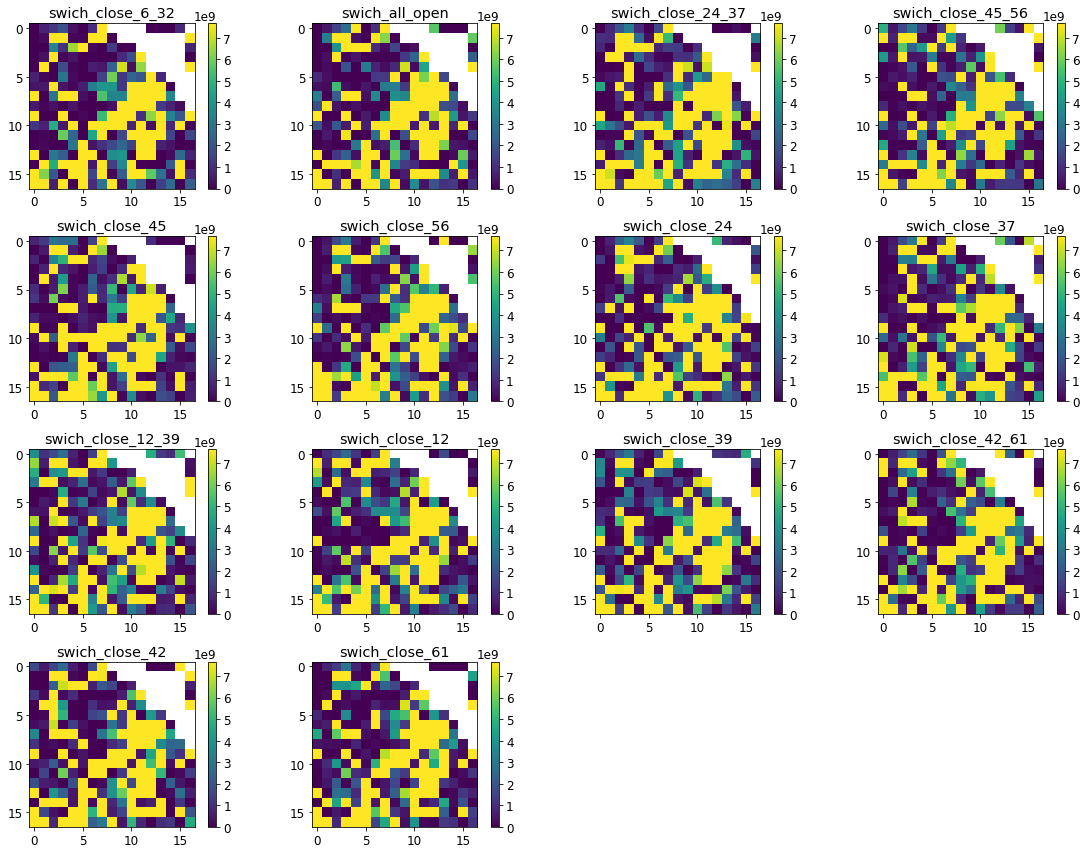

In [152]:
rc('figure',figsize=(16,12))
mm,ss = ft.meancut(allres_tot[:,:,2],3)
allimg = np.zeros((len(dirs), 17, 17))
for i in xrange(len(dirs)):
    subplot(4,4,i+1)
    amps = allres_tot[i,:,2]
    img = ft.image_asics(all1=amps)
    allimg[i,:,:] = img
    imshow(img, vmin=0, vmax=5*ss)
    colorbar()
    title(labels[i])
tight_layout()

<ErrorbarContainer object of 3 artists>

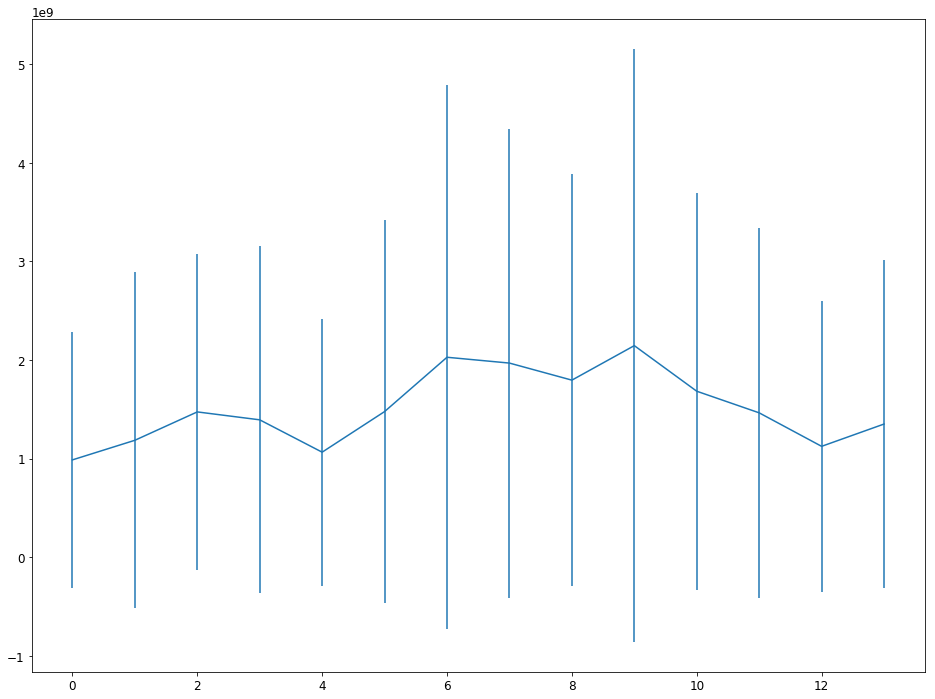

In [154]:
mval = np.zeros(14)
sval = np.zeros(14)
for i in xrange(14):
    truc = allimg[i,:,:]
    mval[i], sval[i] = ft.meancut(truc[np.isfinite(truc)],3)
errorbar(arange(14),mval,yerr=sval)


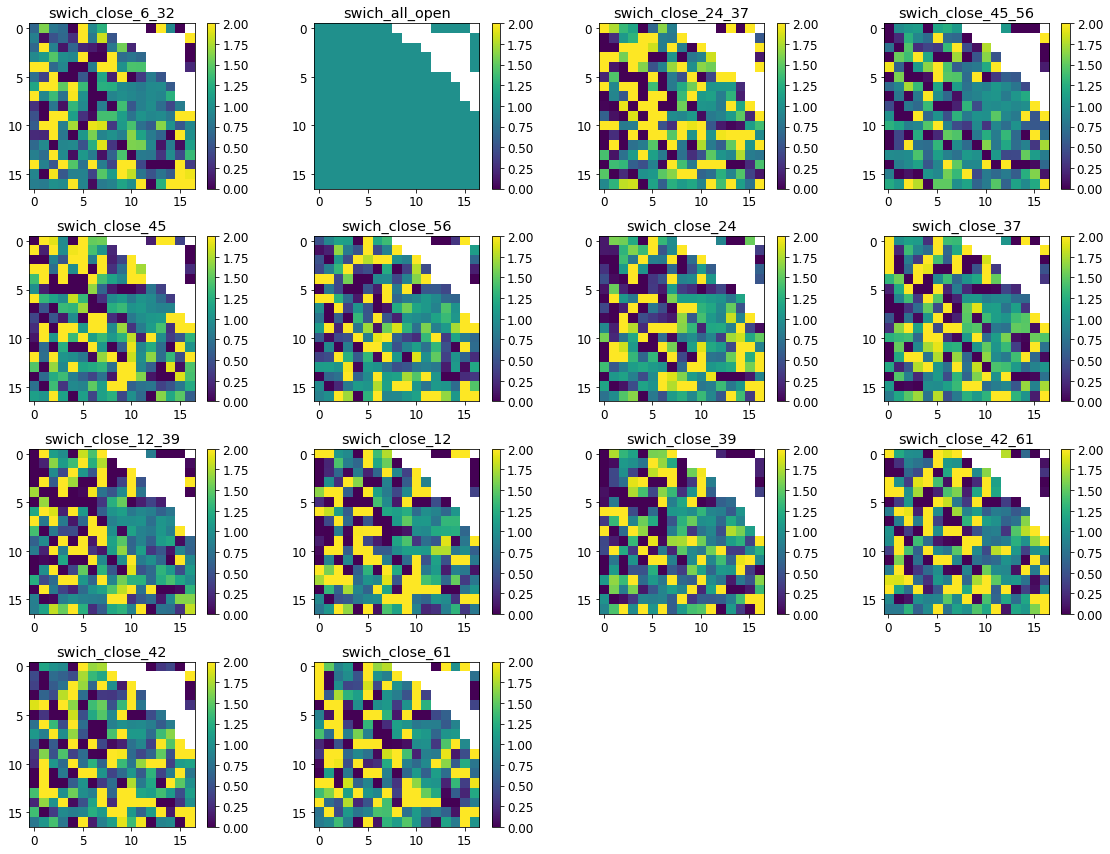

In [141]:
rc('figure',figsize=(16,12))
mm,ss = ft.meancut(allres_tot[:,:,2],3)
allimg = np.zeros((len(dirs), 17, 17))
for i in xrange(len(dirs)):
    amps = allres_tot[i,:,2]
    allimg[i,:,:] = ft.image_asics(all1=amps)

iref = 1
for i in xrange(len(dirs)):
    subplot(4,4,i+1)
    imshow(allimg[i,:,:]/allimg[iref,:,:], vmin=0, vmax=2)
    colorbar()
    title(labels[i])
tight_layout()

In [159]:
amplitudes = allres_tot[:,:,2]

#### This is Stot
index_tot = 1

#### These are C-i, C-j and S-ij
index_24_37 = ['24_37', 6, 7, 2]
index_45_56 = ['45_56', 4, 5, 3]
index_12_39 = ['12_39', 9, 10, 8]
index_42_61 = ['42_61', 12, 13, 11]

allsets = [index_24_37, index_45_56, index_12_39, index_42_61]

allimg = np.zeros((len(allsets), 17, 17))
for iset in xrange(len(allsets)):
    theset = allsets[iset]
    tit = theset[0]
    Stot = amplitudes[index_tot, :]
    #Stot = Stot / np.median(Stot)
    C_i = amplitudes[theset[1], :]
    #C_i = C_i / np.median(C_i) * 63./64
    C_j = amplitudes[theset[2], :]
    #C_j = C_j / np.median(C_j) * 63./64
    S_ij = amplitudes[theset[3], :]
    #S_ij = S_ij / np.median(S_ij) * 62./64
    fringe = Stot + S_ij - C_i - C_j
    allimg[iset,:,:] = ft.image_asics(all1=fringe)

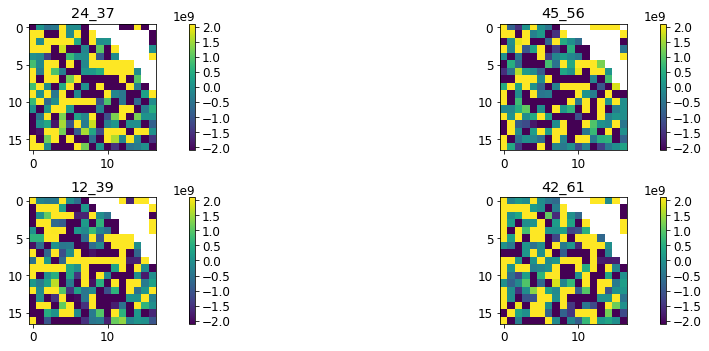

In [160]:
rc('figure',figsize=(16,5))
mm,ss = ft.meancut(allimg[np.isfinite(allimg)],3)
rng = ss
figure()
for i in xrange(4):
    subplot(2,2,i+1)
    imshow(allimg[i,:,:], vmin=-rng, vmax=rng)
    title(allsets[i][0])
    colorbar()

tight_layout()

## Try to normalize by all open

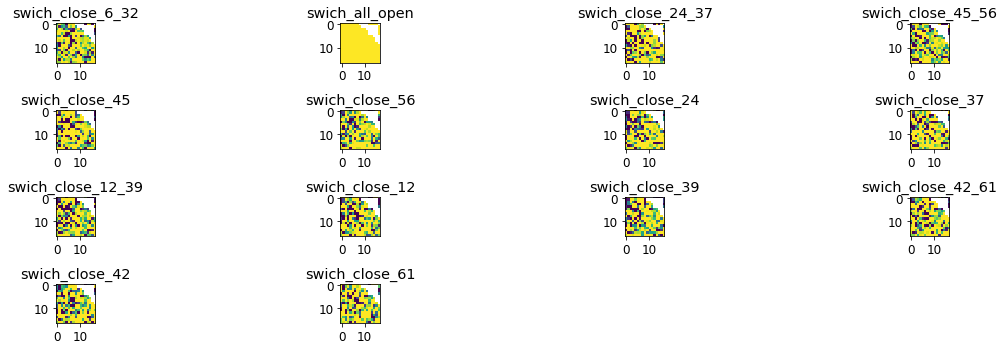

In [110]:
amps_ref = allres_tot[1,:,2]
img_ref = ft.image_asics(all1=amps_ref)

# do lists with amplitudes and images
allamps = []
allimages = []
for i in xrange(len(dirs)):
    amps = allres_tot[i,:,2]
    allamps.append(amps)
    
    img = ft.image_asics(all1=amps)
    allimages.append(img)
    
    subplot(4,4,i+1)
    imshow(img/img_ref, vmin=0, vmax=1)
    title(labels[i])
    
tight_layout()

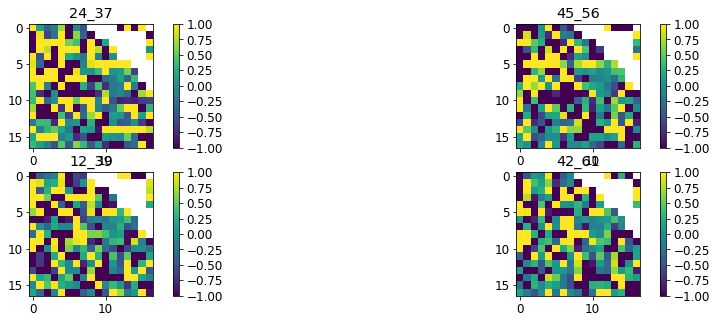

In [116]:
index_24_37 = ['24_37', 6, 7, 2]
index_45_56 = ['45_56', 4, 5, 3]
index_12_39 = ['12_39', 9, 10, 8]
index_42_61 = ['42_61', 12, 13, 11]

allsets = [index_24_37, index_45_56, index_12_39, index_42_61]

Stot = img_ref
figure()
for i in xrange(len(allsets)):
    theset = allsets[i]
    C_i = allimages[theset[1]]
    C_j = allimages[theset[2]]
    S_ij = allimages[theset[3]]
    fringe = S_tot + S_ij - C_i - C_j
    
    subplot(2,2,i+1)
    imshow(fringe/Stot, vmin=-1, vmax=1)
    title(theset[0])
    colorbar()
    